In [9]:
## upload the data in collab  as zip file and extract the zip file content

from zipfile import ZipFile
file_name = "/content/deep-learning-spring-2025-project-1.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')




Done


Using device: cuda
Loading CIFAR-10 data...
Training data shape: (50000, 3, 32, 32), Validation data shape: (10000, 3, 32, 32)


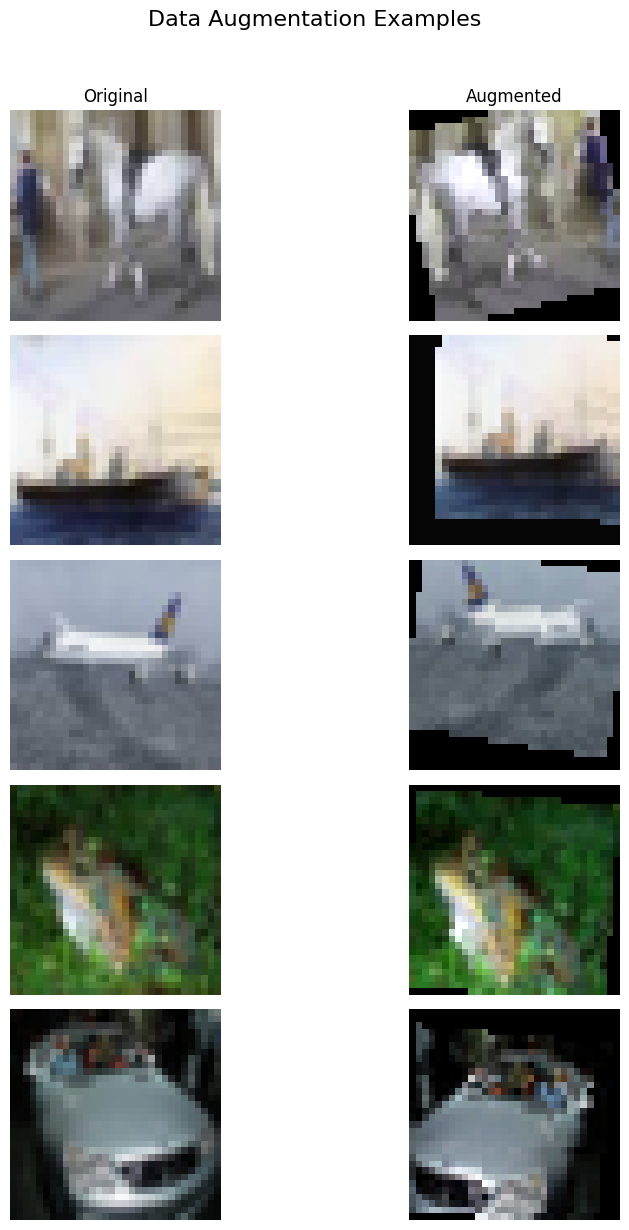

Total parameters: 4,327,754
Starting training...
Epoch: 1/1000, Batch: 50/391, Loss: 2.7127


KeyboardInterrupt: 

In [16]:
##run this to train the model with 1000 epoch

import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import pandas as pd
import copy

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# 1. ResNet Architecture
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class WideResNet(nn.Module):
    def __init__(self, block, num_blocks, width_multiplier=1, num_classes=10, dropout_rate=0.2):
        super(WideResNet, self).__init__()

        # Base width configurations
        self.in_channels = 64

        # Initial layer - no maxpool for CIFAR-10's small images
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)

        # Wider residual blocks
        base_width = int(64 * width_multiplier)
        self.layer1 = self._make_layer(block, base_width, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, base_width*2, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, base_width*4, num_blocks[2], stride=2)

        # Global average pooling and classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(base_width*4, num_classes)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.dropout(out)
        out = self.fc(out)

        return out

# def build_wide_resnet(width_multiplier=2, num_classes=10, dropout_rate=0.2):
#     # A ResNet-20 style architecture with 3 stages, each with 3 blocks
#     return WideResNet(BasicBlock, [3, 3, 3], width_multiplier, num_classes, dropout_rate)
# def build_wide_resnet(width_multiplier=0.75, num_classes=10, dropout_rate=0.2):
#     # A more parameter-efficient ResNet
#     return WideResNet(BasicBlock, [2, 2, 2], width_multiplier, num_classes, dropout_rate)
def build_wide_resnet(width_multiplier=1.0, num_classes=10, dropout_rate=0.2):
    # A slightly larger but still efficient ResNet
    return WideResNet(BasicBlock, [3, 3, 3], width_multiplier, num_classes, dropout_rate)


# 2. Data Handling
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict_data = pickle.load(fo, encoding='bytes')
    return dict_data

def load_cifar_data(cifar10_dir):
    # Load label names
    meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
    label_names = [name.decode('utf-8') for name in meta_data_dict[b'label_names']]

    # Load all training batches
    all_images = []
    all_labels = []

    for i in range(1, 6):
        batch_dict = load_cifar_batch(os.path.join(cifar10_dir, f'data_batch_{i}'))
        batch_images = batch_dict[b'data']
        batch_labels = batch_dict[b'labels']

        # Reshape images to (N, C, H, W) - PyTorch format
        batch_images = batch_images.reshape((-1, 3, 32, 32))

        all_images.append(batch_images)
        all_labels.extend(batch_labels)

    # Combine all batches
    all_images = np.vstack(all_images)

    # Load test data (to use as validation)
    test_dict = load_cifar_batch(os.path.join(cifar10_dir, 'test_batch'))
    test_images = test_dict[b'data'].reshape((-1, 3, 32, 32))
    test_labels = test_dict[b'labels']

    return all_images, all_labels, test_images, test_labels, label_names

def load_unlabeled_test_data(test_file):
    with open(test_file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch[b'data']

class CIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, images, labels=None, transform=None, is_train=True):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.is_train = is_train

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        # Process image based on its format
        if self.is_train:
            # For training/validation data: comes as (C, H, W), needs to be (H, W, C) for PIL
            image = image.transpose(1, 2, 0)  # Change to (H, W, C)

        # Ensure image is uint8 for PIL
        image = Image.fromarray(image.astype('uint8'))

        if self.transform:
            image = self.transform(image)

        if self.labels is not None:
            return image, self.labels[idx]
        else:
            return image

# 3. Data Augmentation and Training Utilities
def mixup_data(x, y, alpha=0.2):
    '''Apply mixup augmentation'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    '''Calculate mixup loss'''
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.classes = classes

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.classes - 1))
            true_dist.scatter_(1, target.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

def get_data_loaders(train_data, train_labels, val_data, val_labels, batch_size=128):
    # Define strong augmentation for enhancing generalization
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
        transforms.RandomAdjustSharpness(sharpness_factor=1.5, p=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.2)),
    ])

    val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]),
    ])

    train_dataset = CIFAR10Dataset(train_data, train_labels, transform=train_transform, is_train=True)
    val_dataset = CIFAR10Dataset(val_data, val_labels, transform=val_transform, is_train=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                           num_workers=2, pin_memory=True)

    return train_loader, val_loader

# 4. Training Function
def train_model(model, train_loader, val_loader, num_epochs=1000, lr=0.1, weight_decay=5e-4,
                mixup_alpha=0.2, label_smoothing=0.1, device='cuda'):
    # Initialize model on the specified device
    model = model.to(device)

    # Set up optimizer and scheduler
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    # Set up criterion with label smoothing
    if label_smoothing > 0:
        criterion = LabelSmoothingLoss(classes=10, smoothing=label_smoothing)
    else:
        criterion = nn.CrossEntropyLoss()

    # Training loop
    best_val_acc = 0.0
    best_model_weights = None
    training_history = {'train_loss': [], 'val_acc': []}

    print("Starting training...")
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            # Apply mixup if alpha > 0
            if mixup_alpha > 0:
                data, targets_a, targets_b, lam = mixup_data(data, target, mixup_alpha)

            optimizer.zero_grad()
            outputs = model(data)

            if mixup_alpha > 0:
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                loss = criterion(outputs, target)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Print progress
            if batch_idx % 50 == 49:
                print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx+1}/{len(train_loader)}, Loss: {running_loss/50:.4f}')
                running_loss = 0.0

        # Validation phase
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        val_acc = 100.0 * correct / total
        training_history['val_acc'].append(val_acc)

        print(f'Epoch: {epoch+1}/{num_epochs}, Validation Accuracy: {val_acc:.2f}%')

        # Update scheduler
        scheduler.step()

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_weights = copy.deepcopy(model.state_dict())
            torch.save(best_model_weights, 'best_model.pth')
            print(f'New best model saved with accuracy: {best_val_acc:.2f}%')

    # Load best model weights
    model.load_state_dict(best_model_weights)

    return model, training_history

# 5. Test Prediction and Submission
def predict_on_test_data(model, test_data, device='cuda'):
    # Create test transform
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]),
    ])

    # Set model to evaluation mode
    model.eval()
    predictions = []

    # Define TTA transforms
    tta_transforms = [
        transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]),
        ]),
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.ToTensor(),
            transforms.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]),
        ]),
    ]

    with torch.no_grad():
        for idx in range(len(test_data)):
            img = test_data[idx]
            # Test data is already in (H, W, C) format according to notes
            img = Image.fromarray(img.astype('uint8'))

            tta_outputs = []
            for transform in tta_transforms:
                input_tensor = transform(img).unsqueeze(0).to(device)
                output = model(input_tensor)
                tta_outputs.append(output)

            # Average predictions from all augmentations
            avg_output = torch.mean(torch.stack(tta_outputs), dim=0)
            _, predicted = torch.max(avg_output.data, 1)
            predictions.append(predicted.item())

    return predictions

def create_submission_file(predictions, output_file='submission.csv'):
    # Create a DataFrame with IDs and predictions
    submission_df = pd.DataFrame({
        'id': range(len(predictions)),
        'label': predictions
    })

    # Save to CSV
    submission_df.to_csv(output_file, index=False)
    print(f'Submission file created: {output_file}')

# Add this function to visualize data augmentation
def visualize_augmentations(images, num_samples=5):
    """
    Visualize original images and their augmented versions.

    Args:
        images: Sample images from CIFAR-10 dataset
        num_samples: Number of images to visualize
    """
    # Define the augmentation pipeline
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
        transforms.RandomAdjustSharpness(sharpness_factor=1.5, p=0.2),
        # Skip normalization and erasing for visualization purposes
    ])

    # Create a figure with subplots
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 2.5))
    fig.suptitle('Data Augmentation Examples', fontsize=16)

    # Set column titles
    axes[0, 0].set_title('Original')
    axes[0, 1].set_title('Augmented')

    # Randomly select images
    indices = np.random.choice(len(images), num_samples, replace=False)

    for i, idx in enumerate(indices):
        # Get the original image
        img = images[idx].transpose(1, 2, 0)  # Change to (H, W, C)
        img = Image.fromarray(img.astype('uint8'))

        # Apply augmentation
        augmented_img = train_transform(img)

        # Display original image
        axes[i, 0].imshow(img)
        axes[i, 0].axis('off')

        # Display augmented image
        axes[i, 1].imshow(augmented_img)
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig('data_augmentation_examples.png')
    plt.show()

# 6. Main Execution
def main():
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Set paths to your data
    cifar10_dir = '/content/cifar-10-python/cifar-10-batches-py'  # Update this path
    unlabeled_test_path = './cifar_test_nolabel.pkl'  # Update this path

    # Load data
    print("Loading CIFAR-10 data...")
    train_data, train_labels, val_data, val_labels, class_names = load_cifar_data(cifar10_dir)
    print(f"Training data shape: {train_data.shape}, Validation data shape: {val_data.shape}")

    visualize_augmentations(train_data, num_samples=5)


    # Create data loaders
    train_loader, val_loader = get_data_loaders(train_data, train_labels, val_data, val_labels, batch_size=128)

    # Build model - adjust width_multiplier to control parameter count
    #model = build_wide_resnet(width_multiplier=2, dropout_rate=0.2)
    model = build_wide_resnet(width_multiplier=1.0, dropout_rate=0.2)
    # Check parameter count
    model.to(device)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")

    if total_params > 5_000_000:
        print("WARNING: Model exceeds 5 million parameter limit!")
        return

    # Train model
    trained_model, history = train_model(
        model,
        train_loader,
        val_loader,
        num_epochs=1000,
        lr=0.1,
        weight_decay=5e-4,
        mixup_alpha=0.2,
        label_smoothing=0.1,
        device=device
    )

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(history['val_acc'])
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.savefig('training_history.png')
    plt.close()

    # Load unlabeled test data and make predictions
    print("Loading unlabeled test data...")
    #test_data = load_unlabeled_test_data(unlabeled_test_path)
    #print(f"Test data shape: {test_data.shape}")

    print("Making predictions on test data...")
    #predictions = predict_on_test_data(trained_model, test_data, device=device)

    # Create submission file
    #create_submission_file(predictions, 'submission.csv')
    print("Done!")

if __name__ == "__main__":
    main()


Using device: cuda
Model loaded with 4,327,754 parameters
Loading CIFAR-10 validation data from /content/cifar-10-python/cifar-10-batches-py...
Validation data loaded with 10000 samples


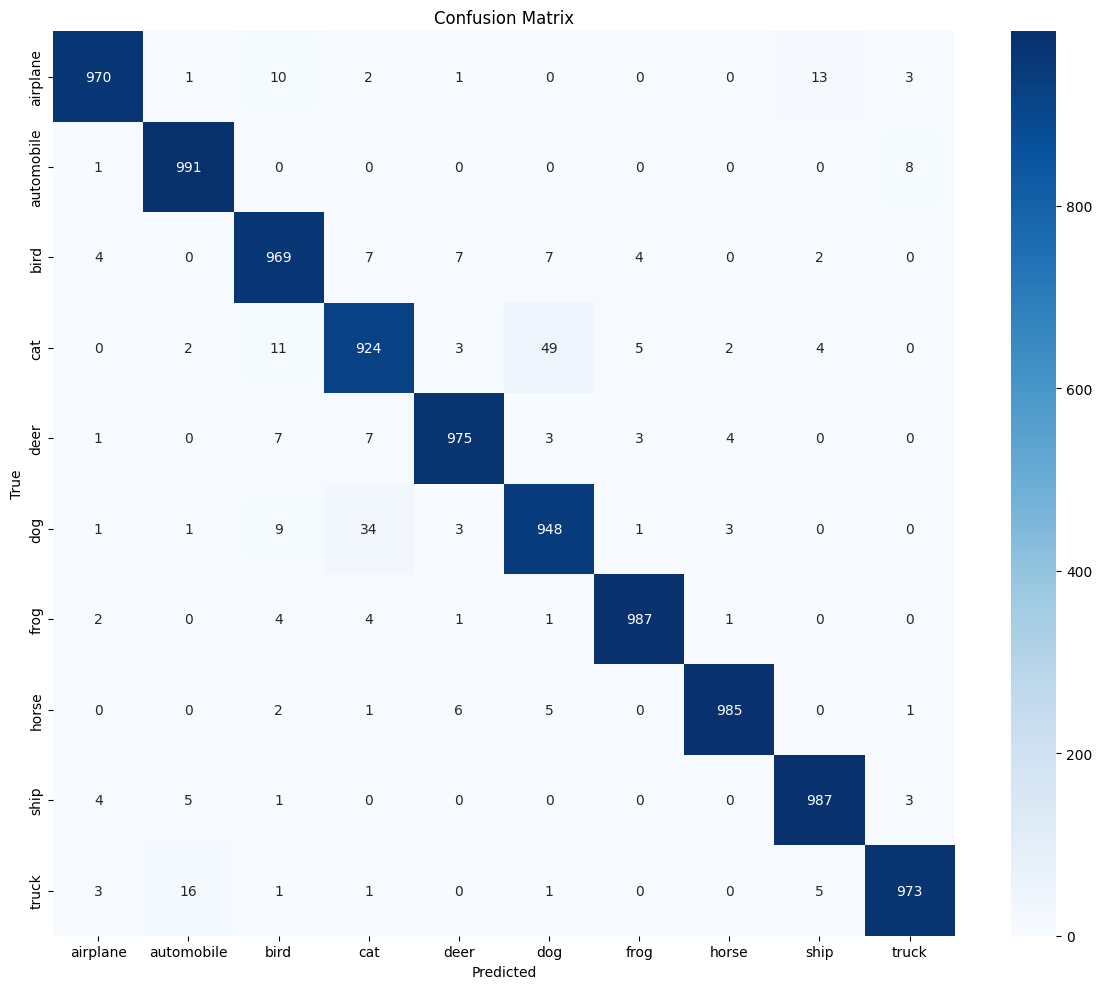


Detailed Classification Report:
              precision    recall  f1-score   support

    airplane     0.9838    0.9700    0.9768      1000
  automobile     0.9754    0.9910    0.9831      1000
        bird     0.9556    0.9690    0.9623      1000
         cat     0.9429    0.9240    0.9333      1000
        deer     0.9789    0.9750    0.9770      1000
         dog     0.9349    0.9480    0.9414      1000
        frog     0.9870    0.9870    0.9870      1000
       horse     0.9899    0.9850    0.9875      1000
        ship     0.9763    0.9870    0.9816      1000
       truck     0.9848    0.9730    0.9789      1000

    accuracy                         0.9709     10000
   macro avg     0.9710    0.9709    0.9709     10000
weighted avg     0.9710    0.9709    0.9709     10000



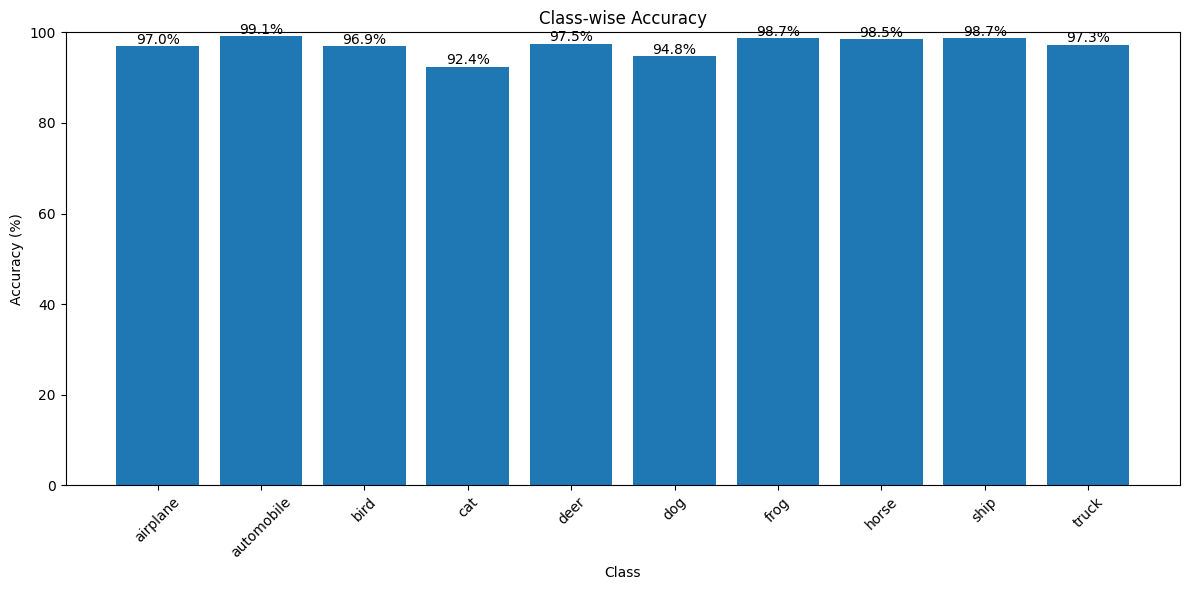


Validation Results:
  Accuracy: 97.09%

Inference Speed Benchmark:
  Average inference time per image: 2.43 ms (± 0.31)
  Throughput: 411.3 images/second


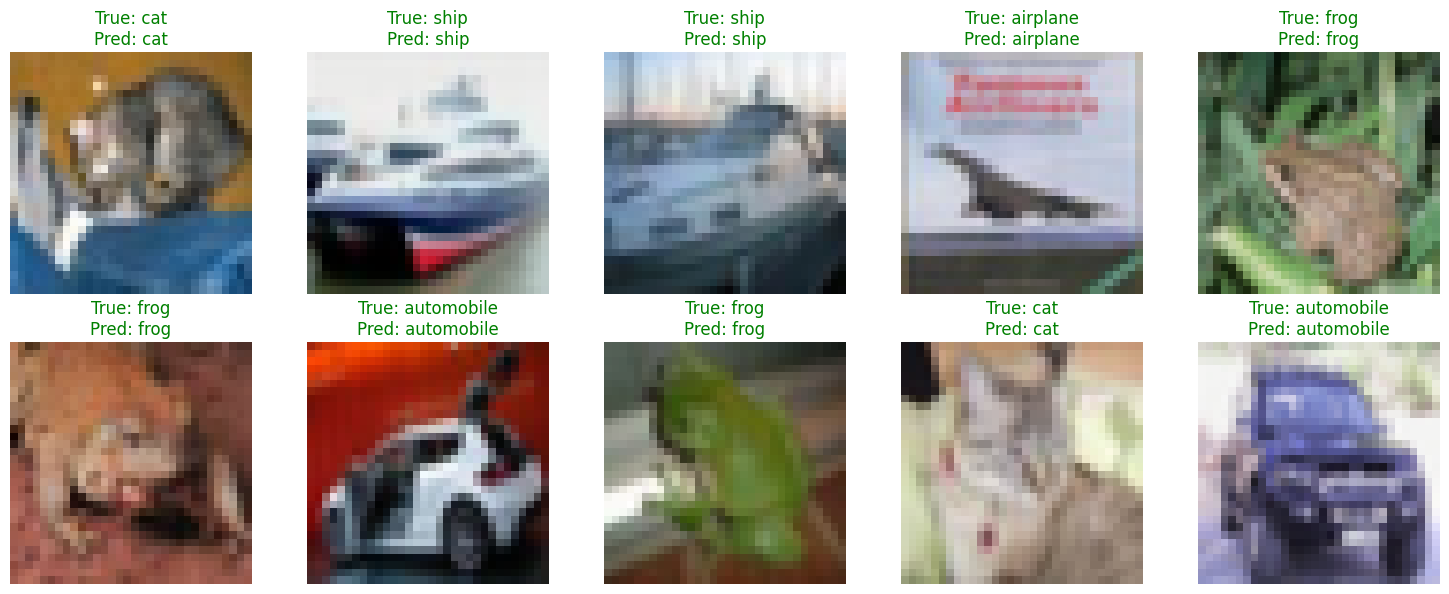

In [17]:
 #Run the model on validation data ,seperately wiht other anlaysis.py
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
import pickle
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import time
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns



def validate_model(model, val_loader, device='cuda', return_predictions=False):
    """
    Validate the model on the validation dataset.
    """
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)

            # Forward pass
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)

            # Collect statistics
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            if return_predictions:
                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

    accuracy = 100.0 * correct / total

    if return_predictions:
        return accuracy, all_preds, all_targets
    return accuracy

def visualize_results(all_preds, all_targets, class_names):
    """
    Visualize the validation results with confusion matrix and other metrics.
    """
    # Convert lists to numpy arrays if they aren't already
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Create confusion matrix
    cm = confusion_matrix(all_targets, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

    # Print classification report
    print("\nDetailed Classification Report:")
    print(classification_report(all_targets, all_preds, target_names=class_names, digits=4))

    # Plot class-wise accuracy
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    plt.figure(figsize=(12, 6))
    bars = plt.bar(class_names, class_accuracy * 100)
    plt.xlabel('Class')
    plt.ylabel('Accuracy (%)')
    plt.title('Class-wise Accuracy')
    plt.xticks(rotation=45)

    # Add accuracy numbers on top of bars
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2,
                bar.get_height() + 0.5,
                f"{class_accuracy[i]*100:.1f}%",
                ha='center')

    plt.ylim(0, 100)
    plt.tight_layout()
    plt.savefig('class_accuracy.png')
    plt.show()

    # Return the overall accuracy
    return np.mean(class_accuracy) * 100

def benchmark_speed(model, input_size=(1, 3, 32, 32), device='cuda', num_runs=100):
    """
    Benchmark the inference speed of the model.
    """
    model.eval()

    # Create dummy input
    dummy_input = torch.randn(input_size).to(device)

    # Warmup
    with torch.no_grad():
        for _ in range(10):
            _ = model(dummy_input)

    # Benchmark
    times = []
    with torch.no_grad():
        for _ in range(num_runs):
            start_time = time.time()
            _ = model(dummy_input)
            end_time = time.time()
            times.append((end_time - start_time) * 1000)  # Convert to ms

    avg_time = np.mean(times)
    std_time = np.std(times)

    print(f"\nInference Speed Benchmark:")
    print(f"  Average inference time per image: {avg_time:.2f} ms (± {std_time:.2f})")
    print(f"  Throughput: {1000/avg_time:.1f} images/second")

    return avg_time

def main():
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Set paths and parameters
    data_dir = '/content/cifar-10-python/cifar-10-batches-py'
    model_path = 'best_model.pth'
    batch_size = 128
    width = 1.0
    dropout = 0.2

    # Build the model with the same architecture used during training
    model = build_wide_resnet(
        width_multiplier=width,
        dropout_rate=dropout
    )

    # Load trained model weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)

    # Display model parameter count
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Model loaded with {total_params:,} parameters")

    # Load CIFAR-10 test set (to use as validation)
    print(f"Loading CIFAR-10 validation data from {data_dir}...")
    _, _, val_data, val_labels, class_names = load_cifar_data(data_dir)
    print(f"Validation data loaded with {len(val_labels)} samples")

    # Define validation transform
    val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]),
    ])

    # Create validation dataset and loader
    val_dataset = CIFAR10Dataset(val_data, val_labels, transform=val_transform, is_train=True)
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=2, pin_memory=True
    )

    # Validate the model with visualizations
    accuracy, all_preds, all_targets = validate_model(
        model, val_loader, device, return_predictions=True
    )

    # Visualize results
    visualize_results(all_preds, all_targets, class_names)

    print(f"\nValidation Results:")
    print(f"  Accuracy: {accuracy:.2f}%")

    # Run inference speed benchmark
    benchmark_speed(model, device=device)

    # Plot per-class validation examples with predictions
    # Visualize model feature activations
    class_counts = {i: 0 for i in range(10)}
    max_examples_per_class = 5
    examples_to_show = []

    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            if all(count >= max_examples_per_class for count in class_counts.values()):
                break

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)

            for i in range(len(labels)):
                label = labels[i].item()
                pred = predictions[i].item()

                if class_counts[label] < max_examples_per_class:
                    class_counts[label] += 1
                    examples_to_show.append((images[i].cpu(), label, pred))

    # Plot some predictions
    rows = 2
    cols = 5
    fig, axs = plt.subplots(rows, cols, figsize=(15, 6))

    for i, (image, label, pred) in enumerate(examples_to_show[:rows*cols]):
        r, c = i // cols, i % cols
        img = image.permute(1, 2, 0).numpy()
        # Denormalize image
        img = img * np.array([0.247, 0.243, 0.261]) + np.array([0.4914, 0.4822, 0.4465])
        img = np.clip(img, 0, 1)

        axs[r, c].imshow(img)
        title_color = "green" if label == pred else "red"
        axs[r, c].set_title(f"True: {class_names[label]}\nPred: {class_names[pred]}",
                          color=title_color)
        axs[r, c].axis('off')

    plt.tight_layout()
    plt.savefig('prediction_examples.png')
    plt.show()

if __name__ == "__main__":
    main()


In [18]:
## Predicition  to generate csv

import torch
import numpy as np
import pandas as pd
import torchvision.transforms as transforms


def predict_test_set(model_path, test_file_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load model
    model = build_wide_resnet(width_multiplier=1.0, dropout_rate=0.2)
    model.to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Model loaded with {total_params:,} parameters")

    # Load the custom test data
    print(f"Loading test data from {test_file_path}")
    test_data = load_cifar_batch(test_file_path)
    test_images = test_data[b'data']
    print(f"Test data shape: {test_images.shape}")

    # Convert to PyTorch tensor and normalize
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])

    # Make predictions
    print("Making predictions on test data...")
    predictions = []
    with torch.no_grad():
        for i, image in enumerate(test_images):
            # Convert to 3D image format
            image = image.reshape(32, 32, 3)

            # Transform and predict
            img = transform(image).unsqueeze(0).to(device)
            output = model(img)
            _, predicted = output.max(1)
            predictions.append(predicted.item())

            if (i+1) % 1000 == 0:
                print(f"Processed {i+1}/{len(test_images)} images")

    # Create submission file
    print("Creating submission file...")
    submission = pd.DataFrame({
        'id': range(len(predictions)),
        'label': predictions
    })
    submission.to_csv('submission.csv', index=False)
    print("Predictions saved to submission.csv")

if __name__ == "__main__":
    predict_test_set('best_model.pth', 'cifar_test_nolabel.pkl')

Using device: cuda
Model loaded with 4,327,754 parameters
Loading test data from cifar_test_nolabel.pkl
Test data shape: (10000, 32, 32, 3)
Making predictions on test data...
Processed 1000/10000 images
Processed 2000/10000 images
Processed 3000/10000 images
Processed 4000/10000 images
Processed 5000/10000 images
Processed 6000/10000 images
Processed 7000/10000 images
Processed 8000/10000 images
Processed 9000/10000 images
Processed 10000/10000 images
Creating submission file...
Predictions saved to submission.csv
